<a href="https://colab.research.google.com/github/alejogiley/Novartis-Hackaton-7/blob/master/Notebooks/Lee_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting affinities of antibiotic candidates to a DNA Gyrase
Dataset from article: _Pyrrolamide DNA Gyrase Inhibitors: Fragment-Based Nuclear Magnetic Resonance Screening To Identify Antibacterial Agents_ Antimicrob Agents Chemother. 2012, 56(3):1240-6.


https://aac.asm.org/content/56/3/1240.long#sec-12

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
import os                # operating system interfaces 

import numpy  as np      # scientific computing: arrays
import scipy  as sp      # scientific computing: statistics
import pandas as pd      # data analysis tools

# Visualization & graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning library
import deepchem as dc

# Machine Learning: randomized decision trees
from sklearn.ensemble import RandomForestRegressor as RFR  
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics  import accuracy_score

from rdkit import Chem               # RDKit libraries for chemistry functions
from rdkit.Chem import Draw          # Drawing chemical structures
from rdkit.Chem import PandasTools   # Manipulating chemical data
from rdkit.Chem import Descriptors   # Calculate molecular descriptors
from rdkit.Chem import rdmolops      # Additional molecular properties
from rdkit.Chem import AllChem       # Morgan (Circular) fingerprints

from rdkit.Chem.Draw import IPythonConsole           # visualizing structures
from rdkit.ML.Descriptors import MoleculeDescriptors # molecular descriptors

Parsing Data
---------------

Dataset is available in the `Github` repository. In order to read in the data, we will use the `pandas` data analysis library. The data is in CSV format and contains SMILES strings, measured $\text{IC50}$ and $K_i$, and a number of other experimental measurements and molecular properties. 



In [11]:
# Dataset address
url = "https://raw.githubusercontent.com/alejogiley/Novartis-Hackaton-7/master/Data/Gyrase/AZ_Pyrrolamides_4OE.csv"

# Load Dataset
df = pd.read_csv(url, encoding="unicode_escape")

# Visualize first 5 rows
df.head(5)

,External_ID,Molecule SMILES,First Sample Reg. Date,SAU Gyr IC50 (µM),SAU Gyr Ki (µM),Sau516 MIC (µg/ml),Sau516 MIC (µM),Mean Human Prot binding (% free),Mean LogD,Determination of pKa HA1,Determination of pKa HA2,Determination of pKa B1,Determination of pKa B2,Sirius pKa
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],6/10/2002,>400,NaN,>64,NaN,NaN,NV,NaN,NaN,NaN,NaN,NaN
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,8/16/2002,>50,NaN,>64,NaN,NaN,>4,NaN,NaN,NaN,NaN,NaN
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,8/16/2002,7.14,NaN,>64,NaN,NaN,>3.66,NaN,NaN,NaN,NaN,NaN
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,8/16/2002,9.93,NaN,>64,NaN,NaN,>3.13,NaN,NaN,NaN,NaN,NaN
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,8/16/2002,3.31,NaN,>64,NaN,NaN,>4.07,NaN,NaN,NaN,NaN,NaN


To get a quick glimpse of the dataset, lets calculate e.g. the number of ligands, the chemical space variability and the range of experimentally measured affinities.

In [20]:
print("Number of molecules on dataset: %i" % (df['Molecule SMILES'].count() + 1)) # Number of non-NA/NaN rows
print("Number of IC50 values: %i" % (df['SAU Gyr IC50 (µM)'].count() + 1))        # Number of non-NA/NaN rows
print("Number of Ki values: %i" % (df['SAU Gyr Ki (µM)'].count() + 1))            # Number of non-NA/NaN rows

Number of molecules on dataset: 982
Number of IC50 values: 982
Number of Ki values: 445


SMILES
---------

The only two fields that are useful to our model are the molecular SMILES and the experimental $\text{IC50}$ and $K_i$. First thing to do is to process the SMILES strings with the `RDKit` module. The SMILES can be converted to a `Mol` object, with bond connectivity and molecular properties. In `RDKit` the majority of the basic molecular functionality is found in module `rdkit.Chem`.


In [0]:
# Get SMILES
pp = pd.DataFrame()                                              # New dataframe 
pp[['ID','Smiles']] = df[['External_ID','Molecule SMILES']]      # Rename headers
pp['ProblematicSmiles'] = pd.Series()                            # Create a new column for SMILES \
                                                                 # that can't be parsed with RDKit

In [74]:
# Get Smiles
pp = pd.DataFrame()
pp[['ID','Smiles']] = df[['External_ID','Molecule SMILES']]
pp['ProblematicSmiles'] = pd.Series()

# Flag bad smiles
def smile2mol(x):
  m = Chem.MolFromSmiles(x)
  if m is None:
    return None
  else:
    return m

# Get Mol objects 
pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))

# find index of problematic smiles
ps = [ k for k,v in enumerate(pp['Molecule']) if v is None ]

# Fix problematic smiles ??
if len(ps) > 0:
  
  print("Having problem getting structures for these smiles:")
  pp['ProblematicSmiles'] = pp['Smiles'].loc[ps]
  
  for i in range(len(ps)):
    print("index: %i" % ps[i], pp['ProblematicSmiles'].loc[ps[i]])
  
  print("Replacing character \'\\2\' with \'2\'")
  pp['Smiles'] = pp['Smiles'].str.replace('\2','2', regex=True)
  
  print("Regenerating molecules")
  pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))
  
  if False in pp['Molecule'].isnull():
    print("No problema compadre")

RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3ncc(s3)C=O)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OCC=C)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NCCOC)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)C(=O)NC)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NC)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4COC)Cl)Cl'
RDKit ERROR: [04:39:08] SMILES Parse Error: syntax error for input: 'Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4[nH]ccn4)Cl)Cl'
RDKit ERROR: [04:39:08] SMILE

Having problem getting structures for these smiles:
index: 698 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3ncc(s3)C=O)Cl)Cl
index: 701 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OCC=C)C(=O)NCCOC)Cl)Cl
index: 702 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NCCOC)Cl)Cl
index: 707 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)C(=O)NC)Cl)Cl
index: 708 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)NC)Cl)Cl
index: 714 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4COC)Cl)Cl
index: 715 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4[nH]ccn4)Cl)Cl
index: 717 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)C(=O)N)Cl)Cl
index: 733 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)c4nccn4CCOC)Cl)Cl
index: 736 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O)c4nccn4CCOC)Cl)Cl
index: 741 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)OC)c4ncnn4C)Cl)Cl
index: 744 Cc1c(c(c([nH]1)C(=O)NCCCN(C/C2=N\OC)c3nc(c(s3)C(=O)O

Descriptors
------------------

RDKit molecular descriptors

In [75]:
# Descriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors) 

# Make is easier to identify problematic molecules later
# e.g infity descriptor values
def computeDescriptors(mol, calculator):
  res = np.array(calculator.CalcDescriptors(mol))
  if not np.all(np.isfinite(res)):
    return None 
  return res 

# Selecting only non-null molecules 
pp = pp[ pp["Molecule"].notnull() ]

# Mapping descriptors with molecules
pp['Descriptors'] = pp['Molecule'].map(lambda x: computeDescriptors(x, calculator)) 

# Flags problems
ps = pp["Descriptors"].isnull()
print("{} molecules failed to get descriptors".format(ps.sum())) 

# Rename columns
des = pp["Descriptors"].apply(pd.Series)
des = des.rename(columns = lambda x : descriptors[x])

0 molecules failed to get descriptors


In [77]:
# Concatenating main and descriptor dataframes
dataset = pd.concat([pp[["ID", "Smiles"]], df["SAU Gyr IC50 (µM)"], des], axis=1)
dataset = dataset.dropna(how ='any')
dataset[descriptors].head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,...,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.198481,-0.435597,12.198481,0.013283,0.623001,384.223,369.103,383.055195,132.0,0.0,0.311075,-0.350740,0.350740,0.311075,1.400000,2.120000,2.720000,1.606288,782.714558,17.974327,13.037493,14.549351,11.952397,7.646576,8.402505,5.682961,6.468125,4.062271,4.755185,2.799838,3.112547,-2.32,5.332598e+05,17.501340,7.283006,3.853433,152.831853,15.200677,10.847038,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.517532,-0.411106,12.517532,0.011515,0.550709,436.310,414.134,435.090602,144.0,0.0,0.311075,-0.353241,0.353241,0.311075,1.444444,2.148148,2.740741,1.607439,843.272683,19.551677,15.236879,16.822875,12.863081,8.900969,9.693967,6.937354,7.791691,4.712163,5.368251,3.261192,4.047073,-2.42,1.314876e+06,19.344590,8.077319,4.292290,165.187695,15.200677,5.693928,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.472623,-0.518193,12.472623,0.024077,0.644188,474.359,450.167,473.106252,158.0,0.0,0.339176,-0.462356,0.462356,0.339176,1.366667,2.066667,2.633333,1.707098,983.301265,21.836134,17.211935,18.797931,14.332938,9.833892,10.626890,7.232812,8.087149,5.061381,5.885049,3.519471,3.847515,-2.86,5.145049e+06,21.839461,9.303515,4.648309,183.297193,19.937540,23.144464,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.298197,-0.085370,12.298197,0.085370,0.847033,388.269,370.125,387.069472,124.0,0.0,0.267458,-0.355369,0.355369,0.267458,1.500000,2.250000,2.875000,1.591350,767.018857,17.104084,13.343032,14.929029,11.579719,7.842445,8.635443,5.877107,6.731444,4.232941,5.056609,2.890092,3.218135,-2.33,3.779222e+05,16.525072,7.054447,3.436063,148.562357,15.200677,17.581012,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.387258,-0.040667,12.387258,0.040667,0.681761,413.319,392.151,412.089873,134.0,0.0,0.267458,-0.356445,0.356445,0.267458,1.230769,2.000000,2.730769,1.376538,924.389107,18.095647,14.627869,16.213866,12.597357,8.866938,9.659936,6.752885,7.607222,4.933988,5.757655,3.402552,3.730596,-2.34,1.351091e+06,17.092841,7.113005,3.464258,160.486499,15.200677,11.511791,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get rid of IPC and descriptor with all zero values

In [0]:
# Drop IPC!!!!
dataset = dataset.drop(['Ipc'], axis=1)

# Drop empty columns
col = list(dataset.head(1))
for c in col[1:]:
  if dataset[c].sum() == 0:
    dataset = dataset.drop([c], axis=1)

Remove correlated descriptors

In [79]:
# Create correlation matrix
corr_matrix = dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
for col in to_drop:
    dataset.drop(col, axis=1, inplace=True)
    
# Update descriptors
descriptors = list(dataset.head(1))[3:]
dataset[descriptors].head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,BalabanJ,BertzCT,HallKierAlpha,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,...,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_bicyclic,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_imidazole,fr_ketone,fr_lactam,fr_methoxy,fr_morpholine,fr_nitro,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.198481,-0.435597,0.013283,0.623001,384.223,0.311075,-0.350740,1.400000,2.120000,1.606288,782.714558,-2.32,3.853433,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,0.000000,15.284746,0.0,18.883484,17.989423,50.379934,0.000000,10.216698,11.505249,0.0,23.201880,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.517532,-0.411106,0.011515,0.550709,436.310,0.311075,-0.353241,1.444444,2.148148,1.607439,843.272683,-2.42,4.292290,15.200677,5.693928,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,13.847474,46.822227,41.561212,4.923311,9.717848,33.342373,0.000000,15.284746,0.0,38.648865,17.989423,50.370839,0.000000,10.216698,11.505249,0.0,15.929944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.472623,-0.518193,0.024077,0.644188,474.359,0.339176,-0.462356,1.366667,2.066667,1.707098,983.301265,-2.86,4.648309,19.937540,23.144464,0.0,0.000000,5.90718,5.969305,4.794537,9.778516,5.261892,0.0,0.000000,61.675533,34.991929,12.170333,14.325937,33.624292,5.261892,15.284746,0.0,39.654696,24.596305,44.814141,6.069221,10.216698,5.817863,0.0,15.929944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.298197,-0.085370,0.085370,0.847033,388.269,0.267458,-0.355369,1.500000,2.250000,1.591350,767.018857,-2.33,3.436063,15.200677,17.581012,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,5.261892,0.0,0.000000,53.894426,35.494845,5.563451,4.794537,27.654986,5.261892,15.284746,0.0,25.807221,17.989423,45.819972,6.069221,10.216698,5.817863,0.0,15.929944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12.387258,-0.040667,0.040667,0.681761,413.319,0.267458,-0.356445,1.230769,2.000000,1.376538,924.389107,-2.34,3.464258,15.200677,11.511791,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,0.000000,0.0,18.199101,59.960793,34.684225,5.516701,4.794537,38.557911,0.000000,15.284746,0.0,25.807221,17.989423,58.325145,0.000000,10.216698,5.817863,0.0,15.929944,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


For now ignore the qualifiers

In [81]:
# comment this latter
y = dataset['SAU Gyr IC50 (µM)'].str.replace('>', '', regex=True)
y = y.str.replace('<', '', regex=True)
#---------------------
dataset['SAU Gyr IC50 (µM)'] = y.apply(lambda x: np.log(float(x)))

# save in Google Drive
dataset.to_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv')
dataset.head()

,ID,Smiles,SAU Gyr IC50 (µM),MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,BalabanJ,BertzCT,HallKierAlpha,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,...,fr_Ndealkylation1,fr_Ndealkylation2,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_bicyclic,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_imidazole,fr_ketone,fr_lactam,fr_methoxy,fr_morpholine,fr_nitro,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],5.991465,12.198481,-0.435597,0.013283,0.623001,384.223,0.311075,-0.350740,1.400000,2.120000,1.606288,782.714558,-2.32,3.853433,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,0.000000,15.284746,0.0,18.883484,17.989423,50.379934,0.000000,10.216698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,3.912023,12.517532,-0.411106,0.011515,0.550709,436.310,0.311075,-0.353241,1.444444,2.148148,1.607439,843.272683,-2.42,4.292290,15.200677,5.693928,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,13.847474,46.822227,41.561212,4.923311,9.717848,33.342373,0.000000,15.284746,0.0,38.648865,17.989423,50.370839,0.000000,10.216698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,1.965713,12.472623,-0.518193,0.024077,0.644188,474.359,0.339176,-0.462356,1.366667,2.066667,1.707098,983.301265,-2.86,4.648309,19.937540,23.144464,0.0,0.000000,5.90718,5.969305,4.794537,9.778516,5.261892,0.0,0.000000,61.675533,34.991929,12.170333,14.325937,33.624292,5.261892,15.284746,0.0,39.654696,24.596305,44.814141,6.069221,10.216698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,2.295560,12.298197,-0.085370,0.085370,0.847033,388.269,0.267458,-0.355369,1.500000,2.250000,1.591350,767.018857,-2.33,3.436063,15.200677,17.581012,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,5.261892,0.0,0.000000,53.894426,35.494845,5.563451,4.794537,27.654986,5.261892,15.284746,0.0,25.807221,17.989423,45.819972,6.069221,10.216698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,1.196948,12.387258,-0.040667,0.040667,0.681761,413.319,0.267458,-0.356445,1.230769,2.000000,1.376538,924.389107,-2.34,3.464258,15.200677,11.511791,0.0,0.000000,5.90718,0.000000,4.794537,4.983979,0.000000,0.0,18.199101,59.960793,34.684225,5.516701,4.794537,38.557911,0.000000,15.284746,0.0,25.807221,17.989423,58.325145,0.000000,10.216698,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Convert to deepchem dataset

In [82]:
# Load dataset
dataset_file = "/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv"

# Features are already calculated
user_specified_features = descriptors
featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)

# Loader
loader = dc.data.UserCSVLoader(tasks=["SAU Gyr IC50 (µM)"], 
                               smiles_field="Smiles", 
                               id_field="ID", 
                               featurizer=featurizer,
                               verbose=True)

dc_set = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.038 s
TIMING: featurizing shard 0 took 0.055 s
TIMING: dataset construction took 0.120 s
Loading dataset from disk.


/usr/local/lib/python3.6/site-packages/deepchem/data/data_loader.py:126: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X_shard = df.as_matrix(columns=featurizer.feature_fields)


Separate the provided data into train/test subsets 

In [83]:
splitter = dc.splits.RandomSplitter(dataset_file)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dc_set)

Computing train/valid/test indices
TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.


Normalize it to have zero-mean and unit-standard-deviation

In [84]:
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.022 s
Loading dataset from disk.
TIMING: dataset construction took 0.007 s
Loading dataset from disk.
TIMING: dataset construction took 0.008 s
Loading dataset from disk.


Start Fitting

In [0]:
sklearn_model = RFR(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

Evaluate

In [86]:
print("Evaluating model")

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
train_scores = model.evaluate(train_dataset, [metric], transformers)
test_scores  = model.evaluate(test_dataset,  [metric], transformers)

print("Train scores")
print(train_scores)
print("Test_scores")
print(test_scores)

Evaluating model
computed_metrics: [0.9359612112615538]
computed_metrics: [0.6715728299700634]
Train scores
{'pearson_r2_score': 0.9359612112615538}
Test_scores
{'pearson_r2_score': 0.6715728299700634}


In [87]:
def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestRegressor(**model_params)
  return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "n_estimators": [20, 100],
    "max_features": ["auto", "log2", None],
    "n_jobs" = [2]
}

metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/6
hyperparameters: {'n_estimators': 20, 'max_features': 'auto'}
computed_metrics: [0.6387966384106958]
Model 1/6, Metric pearson_r2_score, Validation set 0: 0.638797
	best_validation_score so far: 0.638797
Fitting model 2/6
hyperparameters: {'n_estimators': 20, 'max_features': 'log2'}
computed_metrics: [0.671774550182098]
Model 2/6, Metric pearson_r2_score, Validation set 1: 0.671775
	best_validation_score so far: 0.671775
Fitting model 3/6
hyperparameters: {'n_estimators': 20, 'max_features': None}
computed_metrics: [0.6768631545785939]
Model 3/6, Metric pearson_r2_score, Validation set 2: 0.676863
	best_validation_score so far: 0.676863
Fitting model 4/6
hyperparameters: {'n_estimators': 100, 'max_features': 'auto'}
computed_metrics: [0.6672311154564445]
Model 4/6, Metric pearson_r2_score, Validation set 3: 0.667231
	best_validation_score so far: 0.676863
Fitting model 5/6
hyperparameters: {'n_estimators': 100, 'max_features': 'log2'}
computed_metrics: [0.675502479523

In [93]:
import numpy.random

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
               "nb_epoch": [15000] }

n_features = train_dataset.get_data_shape()[0]

def model_builder(model_params, model_dir):
  model = dc.models.MultitaskRegressor(
    1, n_features, layer_sizes=[2000,1000,1000,500], dropouts=[.25],
    batch_size=50, **model_params)
  return model

optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/1
hyperparameters: {'learning_rate': 0.00040455393000958094, 'decay': 2.845927340022073e-06, 'nb_epoch': 5000}
computed_metrics: [0.6282973134137277]
Model 1/1, Metric pearson_r2_score, Validation set 0: 0.628297
	best_validation_score so far: 0.628297
computed_metrics: [0.9325013507955382]
Best hyperparameters: (0.00040455393000958094, 2.845927340022073e-06, 5000)
train_score: 0.932501
validation_score: 0.628297


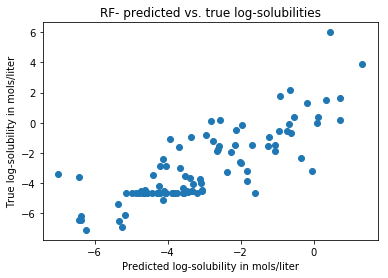

In [94]:
task = "measured log solubility in mols per litre"
predicted_test = best_rf.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'RF- predicted vs. true log-solubilities')
plt.show()

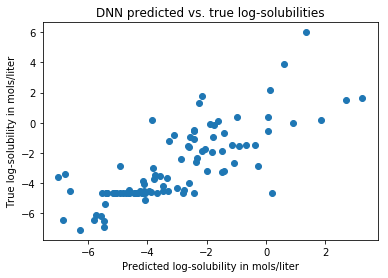

In [95]:
task = "measured log solubility in mols per litre"
predicted_test = best_dnn.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN predicted vs. true log-solubilities')
plt.show()

In [0]:
if __name__ == "__main__":